In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [10]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 2016
pdgId = 13
category = 0
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/'
fpath_bkg['mcitron_mx12_ctau1'] = path + 'signal_125_12_1m_1pb_weighted.root'
# fpath_bkg['mcitron_mx12_ctau10'] = path + 'signal_125_12_10m_1pb_weighted.root'
fpath_bkg['mcitron_mx25_ctau1'] = path + 'signal_125_25_1m_1pb_weighted.root'
# fpath_bkg['mcitron_mx25_ctau10'] = path + 'signal_125_25_10m_1pb_weighted.root'
fpath_bkg['mcitron_mx55_ctau1'] = path + 'signal_125_55_1m_1pb_weighted.root'
# fpath_bkg['mcitron_mx55_ctau10'] = path + 'signal_125_55_10m_1pb_weighted.root'
fpath_bkg['mcitron_mx450_ctau1'] = path + 'signal_1000_450_1m_1pb_weighted.root'
# fpath_bkg['mcitron_mx450_ctau10'] = path + 'signal_1000_450_10m_1pb_weighted.root'
# fpath_bkg['sixie_mx55_ctau1'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v4/normalized/ggH_HToSSTobbbb_ms55_pl1000_RunIIFall18_1pb_weighted.root'



lumi = 137000


NEvents = {}
print(data_year, lumi/1000)
NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
#         tree_bkg[k] = root_dir['ntuples']['llp']
#         NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    NEvents_genweight[k] = root_dir['NEvents_genweight'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print("NEvents_genweight",NEvents_genweight[k])


    print ('weights',np.unique(a)*lumi)
    print(np.sum(a))
    print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)
print(time.time()-start_t)

2016 137.0
mcitron_mx12_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/signal_125_12_1m_1pb_weighted.root
NEvents 131981.0
NEvents_genweight 131964.08
weights [0.21120968 0.65359236 3.17240524 3.228893   3.261508   3.29445269
 3.32773007]
3.2053823
131981
mcitron_mx25_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/signal_125_25_1m_1pb_weighted.root
NEvents 131342.0
NEvents_genweight 131324.89
weights [1.34046447e-05 3.22889300e+00 3.26150800e+00 3.29445269e+00
 3.32773007e+00]
3.1898534
131342
mcitron_mx55_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p12/MC_RunIIFall18/v4/v5/normalized/signal_125_55_1m_1pb_weighted.root
NEvents 127896.0
NEvents_genweight 127880.13
weights [2.9133682  3.261508   3.29445269 3.32773007]
3.1061862
127896
mcitron_mx450_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedj

# Load trigger

In [11]:
trigger_names_file = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
# if wH:
#     trigger_paths = [87,135,136] #PFMET120
# #     elif data_year == 2017: trigger_paths = [87,136] #PFMET120
# else:
trigger_paths = [177,362,87,135,136] #PFMET120
trigger_paths += [84,91]
if category == 0:
    trigger_paths = [310]
xsec = {}
xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


xsec['WJetsToLNu'] = 61526.7

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['SingleElectron'] = 'SingleElectron'
legend['SingleMuon'] = 'SingleMuon'
legend['WJetsToLNu'] = 'WJetsToLNu'

# load bdt

In [12]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v2'
model = pickle.load(open( bdt_name+'.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]
print (y_pred)
# y_pred_train = model.predict_proba(x_train)[:, 1]
# y_pred_bkg = model.predict_proba(df_bkg.values)[:, 1]
# predictions = [round(value) for value in y_pred]
# # evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))


[0.24800783]


In [13]:
import math
def deltaPhi( phi1,  phi2):
    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# nCsc with different hit vetoing

In [14]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
BDT_CUT = 0.467 #90% wp vBDT/v1, bdt_flatten_noEvtSelection
bdtBkgEff =  0.0661076084960519

BDT_CUT = 0.9227871 #90% wp vBDT/v2, bdt_flatten_metfilter_me1112nohits_eta2p1
bdtBkgEff =  0.10278372591006424

intime = True
DPHI_CUT = 1
weight = {}
weight_event = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}
cscClusterSize = {}
cscClusterTime = {}
nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
jetMet_dPhi = {}
jetMet_dPhiMin = {}
jetMet_dPhiMin4 = {}
jetMet_dPhiMin4_50 = {}
npv = {}
rho = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
cscRechitClusterTimeDiff = {}
cscRechitCluster_match_gLLP = {}

cscRechitClusterXSpread = {}
cscRechitClusterYSpread = {}
cscRechitClusterNStation = {}
cscRechitClusterEtaPhiSpread = {}
cscRechitClusterX = {}
cscRechitClusterY = {}
cscRechitClusterZ = {}
cscRechitClusterPhi = {}
cscClusterJetVetoPt = {}
cscRechitClusterEta = {}

cscRechitClusterMaxStationRatio = {}
cscRechitClusterNStation = {}
cscRechitClusterNChamber = {}
cscRechitClusterMet_dPhi = {}
jetMet_dPhiMin30 = {}
dphiMet_cluster = {}
bdt_score = {}
a = {}
b = {}
c = {}
d = {}
legend = {}

legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'

# keys = ['data','mc_intime_bkg','mc_oot_bkg','mc_signal']
keys = ['data_intime','data_oot','mc_signal','mc_bkg']
keys = ['data_intime','mc_signal',]
keys = ['data_intime','mc_signal']
# keys = ['mc_signal']

# keys = ['mc_bkg']
# keys = ['mc_signal','mc_background']
# for k,T in tree_bkg.items():
for k in tree_bkg.keys():
########### SELECTION: CLUSTERS ############
    T = tree_bkg[k]
#     sel_rechitcluster = T.array('cscRechitClusterMaxStationRatio') > 0.6
    sel_rechitcluster =  np.abs(T.array('cscRechitClusterMaxChamber')) > 12
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterEta')) < 2.1)
# # #     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterEta') > 0)

    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterNRechitChamberMinus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitClusterTime') < 12.5, T.array('cscRechitClusterTime') > -5.0))

    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster_match_gLLP') == True)


########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > jetPt_cut, np.abs(T.array('jetEta')) < 2.4 )
    
########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
    sel_ev= np.zeros(hlt[:,0].shape)
    higgs_mass = T.array('gHiggsPt')*np.cosh(T.array('gHiggsEta'))/T.array('gHiggsE')
    sel_ev = np.logical_and(sel_ev, np.abs(higgs_mass-125)<0.004)
    for tr in trigger_paths:            
        sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
        print("trigger",tr,1.0*np.count_nonzero(hlt[:,tr])/len(hlt[:,tr]))
    sel_ev = np.logical_and(sel_ev, T.array('category') == category)

#     sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum() == 1)
    sel_ev = np.logical_and(sel_ev,sel_rechitcluster.sum() >= 1)

    if category == 0:
        sel_ev = np.logical_and(sel_ev,T.array('met') > 200)
        sel_ev = np.logical_and(sel_ev,T.array('nLeptons') == 0)

        sel_ev = np.logical_and(sel_ev, sel_jet.sum()>=1)
    sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) > 0)
    ########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev]

    ##### bdt variables ####
    cscRechitClusterPhi[k] = T.array('cscRechitClusterPhi')[sel_rechitcluster][sel_ev][:,0].flatten()
    print(cscRechitClusterPhi[k].shape)
    cscRechitClusterXSpread[k] = T.array('cscRechitClusterXSpread')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterYSpread[k] = T.array('cscRechitClusterYSpread')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterEtaPhiSpread[k] = T.array('cscRechitClusterEtaPhiSpread')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterX[k] = T.array('cscRechitClusterX')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterY[k] = T.array('cscRechitClusterY')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterZ[k] = T.array('cscRechitClusterZ')[sel_rechitcluster][sel_ev][:,0].flatten()
    bdt_var = {'cscRechitClusterXSpread': cscRechitClusterXSpread[k],
     'cscRechitClusterYSpread': cscRechitClusterYSpread[k],
     'cscRechitClusterNStation':cscRechitClusterNStation[k],
     'cscRechitClusterEtaPhiSpread':cscRechitClusterEtaPhiSpread[k],
     'cscRechitClusterX':cscRechitClusterX[k],
     'cscRechitClusterY':cscRechitClusterY[k],
     'cscRechitClusterZ':cscRechitClusterZ[k],
    }
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1]
    print(len(bdt_score[k]) == np.count_nonzero(sel_ev))
    print("effiency",np.count_nonzero(bdt_score[k]>BDT_CUT)/len(bdt_score[k]))
    bdt_sel = bdt_score[k] < 100*BDT_CUT 

    cscRechitClusterPhi[k] = cscRechitClusterPhi[k][bdt_sel]
    cscRechitClusterEta[k] = T.array('cscRechitClusterEta')[sel_rechitcluster][sel_ev][:,0].flatten()
    cscRechitClusterEta[k] = cscRechitClusterEta[k][bdt_sel]
    cscRechitClusterNStation[k] = T.array('cscRechitClusterNStation')[sel_rechitcluster][sel_ev][:,0].flatten()[bdt_sel]
    
   
    
    
    dphiMet_cluster[k] = np.abs(T.array('cscRechitClusterMet_dPhi'))[sel_rechitcluster][sel_ev][:,0].flatten()[bdt_sel]
    metPhi[k] = T.array('metPhi')[sel_ev][bdt_sel]
    met[k] = T.array('met')[sel_ev][bdt_sel]

    nJets[k] = T.array('nJets')[sel_ev][bdt_sel]

    jetPhi[k] = T.array('jetPhi')[sel_ev][bdt_sel]
    jetPt[k] = T.array('jetPt')[sel_ev][bdt_sel]
    jetMet_dPhiMin30[k] = []
    for ev in range(len(jetPhi[k])):
        dphi_min_temp = 999
        for i in range(len(jetPhi[k][ev])):
            if jetPt[k][ev][i] < 30: continue
            dphi_temp = abs(deltaPhi(metPhi[k][ev],jetPhi[k][ev][i]))
            if dphi_min_temp > dphi_temp: dphi_min_temp = dphi_temp
        jetMet_dPhiMin30[k].append(dphi_min_temp)
    jetMet_dPhiMin30[k] = np.array(jetMet_dPhiMin30[k])
    
    jetMet_dPhiMin4[k] = T.array('jetMet_dPhiMin4')[sel_ev][bdt_sel]
    jetMet_dPhiMin[k] = T.array('jetMet_dPhiMin')[sel_ev][bdt_sel]
    jetMet_dPhi[k] = T.array('jetMet_dPhi')[sel_ev][bdt_sel]
    weight[k] = T.array('weight')[sel_ev][bdt_sel]
    npv[k] = T.array('npv')
    npu[k] = T.array('npu')
    genMet[k] = T.array('genMetPtTrue')
#     dphiMet_cluster[k] = []
#     for ev in range(len(cscRechitClusterPhi[k])):
#         dphiMet_cluster[k].append(abs(deltaPhi(cscRechitClusterPhi[k][ev],metPhi[k][ev])))
#     dphiMet_cluster[k] = np.array(dphiMet_cluster[k])
    print("before weight")
    
    pileupWeight[k] = T.array('pileupWeight')[sel_ev][bdt_sel]
   
    weight[k] = weight[k]*lumi
    ##### clusters #####
    cscClusterTime[k] = T.array('cscRechitClusterTime')[sel_rechitcluster][sel_ev][bdt_sel][:,0]
    cscClusterSize[k] =  T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev][bdt_sel]
    cscClusterJetVetoPt[k] =  T.array('cscRechitClusterJetVetoPt')[sel_rechitcluster][sel_ev][bdt_sel][:,0]

    nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] = cscClusterSize[k][:,0]
#         nCscClusters[k] = cscClusterSize[k].count()
   

trigger 310 0.5939945901303976
(1678,)
True
effiency 0.039928486293206195
before weight
trigger 310 0.46356078025307973
(1775,)
True
effiency 0.041690140845070424
before weight
trigger 310 0.23546475261149685
(720,)
True
effiency 0.05277777777777778
before weight
trigger 310 0.08847184986595175
(65,)
True
effiency 0.015384615384615385
before weight
CPU times: user 3.41 s, sys: 201 ms, total: 3.61 s
Wall time: 7.06 s


## Distribution for event level variables

mcitron_mx12_ctau1 1678
mcitron_mx25_ctau1 1775
mcitron_mx55_ctau1 720
mcitron_mx450_ctau1 65


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: mcitron_mx12_ctau1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mcitron_mx25_ctau1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mcitron_mx55_ctau1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: mcitron_mx450_ctau1 (Potential memory leak).


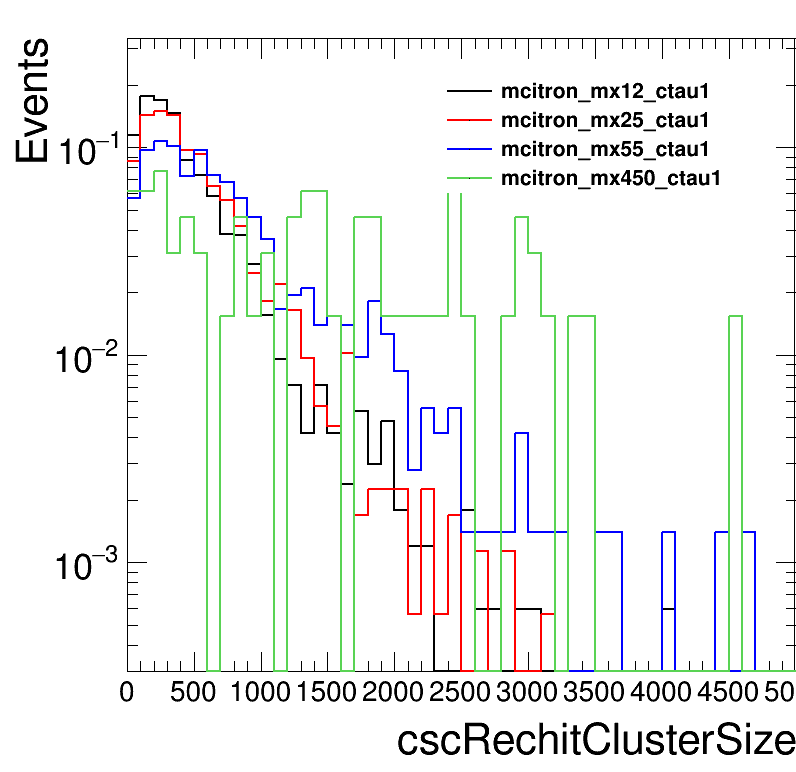

In [16]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.55,0.75,0.87,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)

# Plotting ncsc
start_t = time.time()


h = {}
rt.gStyle.SetOptFit(1011)

for i,k in enumerate(tree_bkg.keys()):
#     h[k] = create_TH1D( nLeptons[k][cond], axis_title=['N_{lep}', 'Events'], name=k, binning=bins)

    h[k] = create_TH1D( jetPt[k][jetPt[k]>50].flatten(), axis_title=['jetPt[GeV]', 'Events'], name=k, binning=[15,0,500])
#     h[str(i)] = create_TH1D( jetPt[k][np.logical_and(cond, jetPt[k].count()>0)][:,0], axis_title=['jet p_{T} [GeV]', 'Events'], name=k, binning=[50,0,2500],weights = weight[k][[np.logical_and(cond, jetPt[k].count()>0)]])
#     h[str(i)] = create_TH1D( np.abs(cscRechitClusterPhi[k][cond]), axis_title=['abs(csc cluster \phi)', 'Events'], name=k, binning=[25,0,3.2])
#     h[k] = create_TH1D( cscRechitClusterEta[k], axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,-3.2,3.2],weights = weight[k])
#     h[k] = create_TH1D( np.abs(metPhi[k]), axis_title=['abs(MET \phi)', 'Events'], name=k, binning=[25,0,3.2],weights = weight[k])
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], axis_title=['cscRechitClusterSize', 'Events'], name=k, binning=[50,0,5000])
#     h[k] = create_TH1D( nJets[k], axis_title=['nJets', 'Events'], name=k, binning=[10,0,10])
#     h[k] = create_TH1D( np.abs(jetPhi[k][jetPt[k]>50].flatten()), axis_title=['jet phi', 'Events'], name=k, binning=[10,0,3.2])

#     h[k] = create_TH1D( met[k], axis_title=['met [GeV]', 'Events'], name=k, binning=[30,0,1200])

#     h[k] = create_TH1D( genMet[k], axis_title=['min _{jet>30GeV}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[50,0,200])
    print(k,len(nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]))
#     h[k] = create_TH1D( jetMet_dPhiMin30[k], axis_title=['min _{jet>30GeV}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])
#     h[k] = create_TH1D( npv[k], axis_title=['npv', 'Events'], name=k, binning=[50,0,100])
#     h[str(i)] = create_TH1D( dphiMet_cluster[k][cond], axis_title=['\Delta \phi(cluster,met)', 'Events'], name=k, binning=[25,0,3.2])
#     h[str(i)] = create_TH1D( np.abs(metPhi[k][cond]), axis_title=['met #phi', 'Events'], name=k, binning=[25,0,3.2])
#     h[k] = create_TH1D( jetPhi[k], axis_title=['leading jet #phi', 'Events'], name=k, binning=[25,-3.2,3.2])
#     h[str(i)] = create_TH1D( jetMet_dPhiMin4[k][cond], axis_title=['min _{4jets}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])

#     h[str(i)] = create_TH1D( jetMet_dPhiMin4[k][cond], axis_title=['min _{4jets}\Delta \phi(MET,jet)', 'Events'], name=k, binning=[25,0,3.2])
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k],k)

#     leg.AddEntry(h[str(i)], "N_{rechits} in (%(first)d,%(second)d]"%{"first":previous_cut,"second":cut})

#     print(k,"events after 200: ",np.sum(weight[k][nCsc_JetMuonVetoCluster0p4_Me1112Veto[k]>=0])*br)
#     h[str(i)].SetMaximum(10E2)
#     h[str(i)].SetMinimum(0.1)



#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
#     h[k].Draw('same')

c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

# Roc curve for event level variables

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.2,0.75,0.50,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'MC QCD background'


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
k = 'data_intime'
name = '\Delta \Phi (jet,met)'
name = 'N_{rechits}'
cuts = [50,80,150,2000]
h = create_TH1D( np.abs(cscRechitClusterEta[k][dphiMet_cluster[k]<0.5]), axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,0,2.5])
h2 = create_TH1D( np.abs(cscRechitClusterEta[k]), axis_title=['csc cluster #eta', 'Events'], name=k, binning=[25,0,2.5])
leg.AddEntry(h,"dphi(met, cluster) < 0.5")
leg.AddEntry(h2,"inclusive")

h.SetLineColor(std_color_list[0])
h2.SetLineColor(std_color_list[1])

h.DrawNormalized('same E1')
h2.DrawNormalized('same E1')


c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

In [ ]:
np.arange(3.0,7.0,0.1)

# Data plot

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

legend = {}
legend['data_oot'] = 'Data OOT region'
legend['data_intime'] = 'Data in-time region'
legend['mc_signal'] = 'signal MC in time'
legend['mc_intime'] = 'MC in-time background'
legend['mc_oot'] = 'MC OOT background'
legend['mc_bkg'] = 'QCD 50toInf background'




keys = ['data_intime','data_oot','mc_signal',]
keys = ['data_intime','mc_signal',]


h = {}
rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
for i,k in enumerate(keys):

#     if k == 'data_intime':
#         cond = nCsc_JetMuonVetoCluster0p4_Me1112Veto[k] < 200
        
#     else:
#         cond = np.ones(weight[k].shape, dtype=bool)
#     cond = np.logical_and(cond, jetMet_dPhiMin4[k]>0.25)
    if k == 'mc_signal':
        br = 1
    else: br = 1
#     if k == 'mc_background':br = 1
    bins = [50,0,1000]
    metcut = 200
    h[k] = create_TH1D( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k][cond], axis_title=['N_{rechits}', 'Events'], name=k, binning=bins,weights = br*weight[k][cond])
    h[k].SetLineColor(std_color_list[i])
    print("weight",weight[k][0])
    leg.AddEntry(h[k], legend[k]+" (scaled)" if k == 'data_oot' else legend[k])
#     if k == 'mc_signal':
#         for i in range(h[k].GetNbinsX()):
#             s = 0.015*h[k].GetBinContent(i+1)
#             b = h['data_oot'].GetBinContent(i+1)
#             if s+b == 0:continue
#             sig = s/(s+b)**0.5
#             print(i,h[k].GetBinCenter(i+1),sig,s,b)
#             if sig < 1./100:
#                 print(i,sig)
#                 continue
#     h[k].SetMinimum(1)

#     r = h[k].Fit('expo', 'LRSQ+', '', 50,400)
#     print(r.Get())
#     print(r.Prob())
#     h[k].GetFunction("expo").SetLineColor(std_color_list[2])
#     h[k].GetFunction("expo").SetLineWidth(2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].SetMinimum(0.1)
    h[k].SetMaximum(10E6/2)
#     h[k+'met'].GetXaxis().SetLabelSize(0.02)
    if k == 'data_oot':
        scale = 1.0*h['data_intime'].GetBinContent(4)/h['data_oot'].GetBinContent(4)
#         for i in range(10):
#             print(1.0*h['data_intime'].GetBinContent(i+1)/h['data_oot'].GetBinContent(i+1))
        h[k].Scale(scale)
    if k[:4] == 'data':
        h[k].Draw('same E1')
    else:
        h[k].Draw("same hist")
#     h[k+'met'].DrawNormalized('same')
    

# c = make_ratio_plot([h['mc'],h['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,3])
c.SetRightMargin(0)
c.SetLogy()
leg.Draw()

c.Draw()
# print(time.time()-start_t)

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.5,0.80,0.90,0.90)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()


k = 'data_intime'

h = {}
rt.gStyle.SetOptFit(1011)

bins = [40,0,1000]
metcut = 200

# cscRechitClusterMaxChamber = {}
# cscRechitClusterNChamber = {}
# cscRechitClusterNStation = {}
# cscRechitClusterMaxStationRatio = {}
# cscRechitClusterMaxChamberRatio = {}

# h[k] = create_TH1D( cscRechitClusterMaxChamber[k], axis_title=['max chamber', 'Events'], name=k, binning=[200,-50,50])
h[k] = create_TH1D( cscRechitClusterMaxChamberRatio[k], axis_title=['max chamber ratio', 'Events'], name=k, binning=[20,0,1])
# h[k] = create_TH1D( cscClusterMet_dPhi[k], axis_title=['#Delta#phi(MET, cluster)', 'Events'], name=k, binning=[20,0,3.14])
# h[k] = create_TH1D( n_chamber[k], axis_title=['Number of Chambers', 'Events'], name=k, binning=[10,0,10])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['max station', 'Events'], name=k, binning=[5,0,5])
# print(cscRechitClusterMaxStationRatio[k])
# h[k] = create_TH1D( cscRechitClusterNStation[k], axis_title=['Number of station', 'Events'], name=k, binning=[20,0,10])


# h['1jet'].GetXaxis().SetLabelSize(0.04)
# h['1jet'].SetMinimum(0.1)
# h['1jet'].SetMaximum(10E6/2)

h[k].Draw('hist')


c.SetRightMargin(0)
c.SetLogy()

c.Draw()
# print(time.time()-start_t)

## significance

In [ ]:
start_t = time.time()
#ROC curve
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.80,0.85,0.92)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)

var = [nCsc_JetMuonVetoCluster0p4_Me1112Veto,]
name = ['nCsc_JetMuonVetoCluster0p4_Me1112Veto',]
legend = [ 'jet & muon veto + ME11/12 veto',]

bkg_k = 'data_oot'
sig_k = 'mc_signal'
br = 0.01

threshold = list(range(300))
threshold = np.array(list(range(2000)))
# print(threshold)
for i in range(len(var)):
    event_count = {}
    
    for k in ['data_oot','mc_signal']:
        event_count[k] = []
        for th in threshold:
            event_count[k].append(np.sum(weight[k][var[i][k]>th]))
        event_count[k] = np.array(event_count[k])
        if k == sig_k:
            event_count[k] = event_count[k]*br
    sig = event_count[sig_k]/np.sqrt(event_count[sig_k]+event_count[bkg_k])
    cond = event_count[sig_k]>0
    sig = sig[cond]
    ncsc = threshold[cond]
#     gr['bbbb'] = create_TGraph(eff_bkg,eff_sig,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    h[sig_k+str(i)] = create_TGraph(ncsc, sig,  axis_title=['N_{rechits}', 'Significnace'])
#     h[sig_k+str(i)] = create_TGraph(ncsc, event_count[sig_k],  axis_title=['N_{rechits}', 'Event Yield'])

    h[sig_k+str(i)].SetLineWidth(2)
    h[sig_k+str(i)].SetMarkerColor(std_color_list[i])
    h[sig_k+str(i)].SetLineColor(std_color_list[i])
    h[sig_k+str(i)].GetXaxis().SetRangeUser(0, 3000)
    h[sig_k+str(i)].GetXaxis().SetLabelSize(0.04)

#     h[sig_k+str(i)].GetYaxis().SetRangeUser(0, 3)


    leg.AddEntry(h[sig_k+str(i)],sig_k+" "+legend[i])
    h[sig_k+str(i)].Draw('ac' if i == 0 else 'c')

#     h[sig_k+str(i)].Draw('ac' if i==0 else 'c')
#     gr['bbbb'].Draw('')




# c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

print(time.time()-start_t)


# 2d plot

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], jetMet_dPhiMin4[k])),
                   axis_title = ['N_{rechits}','min_{4jet}\Delta\phi (jet,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# third

# ROC Curve

# 4th

# nCsc histogram

# event yield vs. ncsc

# significance